In [9]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [2]:
dataset = pd.read_csv('dataset.csv')
dataset.head()

,date,steps,bedin,bedout,sleep duration,deepduration,lightduration,timezone,sex,age,height
0,2016-04-02,2547.55,23.78,7.82,7.76,3.24,4.49,1.0,1.0,39.0,174.0
1,2016-04-03,329.53,23.41,6.48,6.93,2.54,4.38,1.0,1.0,39.0,174.0
2,2016-04-05,9031.89,22.95,6.73,7.19,3.04,4.14,1.0,1.0,39.0,174.0
3,2016-04-06,15331.70,22.44,6.18,7.61,3.51,4.14,1.0,1.0,39.0,174.0
4,2016-04-07,5222.45,24.57,4.04,3.38,1.92,1.49,1.0,1.0,39.0,174.0


In [3]:
# Normalizzazione
cols = list(dataset)[1:]
df_training = dataset[cols].astype(float)

scaler = MinMaxScaler()
scaler = scaler.fit(df_training)
df_training_scaled = scaler.transform(df_training)

In [4]:
print(df_training_scaled)

[[0.01500376 0.90356605 0.91388359 ... 1.         0.58666667 0.48351648]
 [0.00193563 0.90201741 0.90749046 ... 1.         0.58666667 0.48351648]
 [0.05320818 0.90009208 0.90868321 ... 1.         0.58666667 0.48351648]
 ...
 [0.04211869 0.90461242 0.91221374 ... 1.         0.54666667 0.50274725]
 [0.05310389 0.90913276 0.91173664 ... 1.         0.54666667 0.50274725]
 [0.04125955 0.90888163 0.91183206 ... 1.         0.54666667 0.50274725]]


In [5]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [6]:
values = df_training_scaled
reframed = series_to_supervised(values, 1, 2)
reframed.drop(reframed.columns[[0,2,3,4,5,6,7,8,9]], axis=1, inplace=True)
print(reframed.head())

   var2(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)   var6(t)  \
1   0.903566  0.001936  0.902017  0.907490  0.031173  0.011715  0.061088   
2   0.902017  0.053208  0.900092  0.908683  0.032342  0.014021  0.057741   
3   0.900092  0.090325  0.897957  0.906059  0.034231  0.016189  0.057741   
4   0.897957  0.030764  0.906873  0.895849  0.015204  0.008856  0.020781   
5   0.906873  0.068506  0.902603  0.901431  0.024290  0.006042  0.056625   

   var7(t)  var8(t)   var9(t)  ...  var1(t+1)  var2(t+1)  var3(t+1)  \
1      1.0      1.0  0.586667  ...   0.053208   0.900092   0.908683   
2      1.0      1.0  0.586667  ...   0.090325   0.897957   0.906059   
3      1.0      1.0  0.586667  ...   0.030764   0.906873   0.895849   
4      1.0      1.0  0.586667  ...   0.068506   0.902603   0.901431   
5      1.0      1.0  0.586667  ...   0.061273   0.895488   0.905677   

   var4(t+1)  var5(t+1)  var6(t+1)  var7(t+1)  var8(t+1)  var9(t+1)  \
1   0.032342   0.014021   0.057741        1.0

In [7]:
# split into train and test sets
values = reframed.values
n_train_hours = len(values)*3//4
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(975968, 1, 20) (975968,) (325323, 1, 20) (325323,)


In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=1, shuffle=False)

Epoch 1/50
13556/13556 [==============================] - 13s 992us/step - loss: 0.0209 - val_loss: 0.0216
Epoch 2/50
13556/13556 [==============================] - 13s 967us/step - loss: 0.0169 - val_loss: 0.0195
Epoch 3/50
13556/13556 [==============================] - 13s 969us/step - loss: 0.0155 - val_loss: 0.0179
Epoch 4/50
13556/13556 [==============================] - 13s 982us/step - loss: 0.0108 - val_loss: 0.0025
Epoch 5/50
13556/13556 [==============================] - 13s 969us/step - loss: 0.0039 - val_loss: 0.0036
Epoch 6/50
13556/13556 [==============================] - 13s 967us/step - loss: 0.0036 - val_loss: 0.0023
Epoch 7/50
13556/13556 [==============================] - 13s 964us/step - loss: 0.0032 - val_loss: 0.0020
Epoch 8/50
13556/13556 [==============================] - 13s 970us/step - loss: 0.0029 - val_loss: 0.0014
Epoch 9/50
13556/13556 [==============================] - 13s 964us/step - loss: 0.0030 - val_loss: 0.0025
Epoch 10/50
13556/13556 [============

NameError: name 'pyplot' is not defined

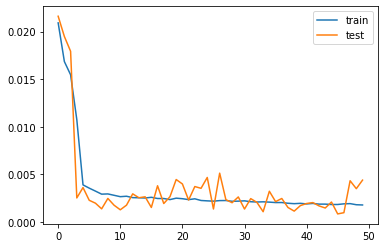

In [10]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()